In [ ]:
# R2 0.720 -  0.7292141914367676 - 0.741 -0.747 -0.7494
#---
# Model
  #Shap Values
  #Name
#---
#Front End
  #Title
  #Languages
  #Manual input
#-----
#Throughout the project
  #Explanation of the code and 頑張ったこと

#Question
# Why I didn'T need anyone's approval to push

# Inital Preparation

In [471]:
#libaraies

import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import ast
import re
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import joblib
import requests


#20250527
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
import numpy as np

#20250528
import json
import requests
from PIL import Image
from io import BytesIO
import ast

#20250601
import shap
import scipy.sparse
from sklearn.neural_network import MLPRegressor

In [472]:
#Price data
script_dir = os.getcwd()  # current working directory

path = os.path.join(script_dir, "../../Data/Raw/prices_cardmarket_20250527.csv")
df_price = pd.read_csv(path)
df_price['market_price_log'] = np.log1p(df_price['market_price'])

In [473]:
# Download latest version
path = kagglehub.dataset_download("adampq/pokemon-tcg-all-cards-1999-2023")
print("Path to dataset files:", path)

Path to dataset files: /Users/suzukikenta/.cache/kagglehub/datasets/adampq/pokemon-tcg-all-cards-1999-2023/versions/1


In [474]:
df = pd.read_csv(os.path.join(path, "pokemon-tcg-data-master 1999-2023.csv"))

In [475]:
# api_key = os.getenv("POKEMON_API_KEY")
# url = "https://api.pokemontcg.io/v2/cards"

# all_cards = []

# for i in range(1, 78):
#     headers = {
#         "X-Api-Key": api_key
#     }
#     params = {
#         "pageSize": 250,
#         "page": i
#     }

#     response = requests.get(url, headers=headers, params=params)
#     response.raise_for_status()  # エラーがあれば例外を出す

#     data = response.json()
#     cards = data.get("data", [])
#     all_cards.extend(cards)  # リストにカードを追加

# print(f"Total cards fetched: {len(all_cards)}")

In [476]:
# # Save the json data to a file
# with open("price_api.json", "w") as f:
#     json.dump(all_cards, f, indent=4)

In [477]:
# # Get prices from cardmarket

# all_cards_1 = []
# skip_count = 0

# for i in range(18775):
#     card = all_cards[i]
#     card_id = card.get("id")

#     # cardmarketとpricesの存在を確認
#     cardmarket = card.get("cardmarket")
#     if not cardmarket:
#         skip_count += 1
#         continue

#     prices = cardmarket.get("prices")
#     if not prices:
#         skip_count += 1
#         continue

#     average_price = prices.get("averageSellPrice")
#     if average_price is None:
#         skip_count += 1
#         continue

#     # 問題なければ追加
#     all_cards_1.append({
#         "id": card_id,
#         "market_price": average_price
#     })

# # ループの外でDataFrame作成
# df_price_cardmarket = pd.DataFrame(all_cards_1)

# print(f"Skipped {skip_count} cards due to missing or invalid cardmarket/prices info.")


In [478]:
# # Get prices from tcgplayer

# all_cards_1 = []
# skip_count = 0

# for i in range(18775):
#     card = all_cards[i]
#     card_id = card.get("id")

#     # cardmarketとpricesの存在を確認
#     tcgplayer = card.get("tcgplayer")
#     if not tcgplayer:
#         skip_count += 1
#         continue

#     prices = tcgplayer.get("prices")
#     if not prices:
#         skip_count += 1
#         continue

#     average_price = prices[list(prices.keys())[0]].get("market")
#     if average_price is None:
#         skip_count += 1
#         continue

#     # 問題なければ追加
#     all_cards_1.append({
#         "id": card_id,
#         "market_price": average_price
#     })

# # ループの外でDataFrame作成
# df_price_tcgplayer = pd.DataFrame(all_cards_1)

# print(f"Skipped {skip_count} cards due to missing or invalid cardmarket/prices info.")


In [479]:
# # # Convert into csv files
# df_price_cardmarket.to_csv("prices_cardmarket_20250527.csv", index=False)
# # df_price_tcgplayer.to_csv("prices_tcgplayer_20250527.csv", index=False)

In [480]:
# Merge the price data with the main DataFrame
df = pd.merge(df, df_price, on='id', how='inner')

In [481]:
df_market = df[["id", "market_price"]].copy()
df_market[['set_id', 'card_id']] = df_market['id'].str.split('-', expand=True)
df_market = df_market.drop(columns=['id'])

# Explatory Data Analysis (EDA)

In [482]:
# The first 5 rows
df.head()

,id,set,series,publisher,generation,release_date,artist,name,set_num,types,...,rarity,flavorText,nationalPokedexNumbers,legalities,resistances,rules,regulationMark,ancientTrait,market_price,market_price_log
0,base1-1,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Alakazam,1,['Psychic'],...,Rare Holo,Its brain can outperform a supercomputer. Its ...,[65],{'unlimited': 'Legal'},NaN,NaN,NaN,NaN,133.99,4.905201
1,base1-2,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Blastoise,2,['Water'],...,Rare Holo,A brutal Pokémon with pressurized water jets o...,[9],{'unlimited': 'Legal'},NaN,NaN,NaN,NaN,93.95,4.553350
2,base1-3,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Chansey,3,['Colorless'],...,Rare Holo,A rare and elusive Pokémon that is said to bri...,[113],{'unlimited': 'Legal'},"[{'type': 'Psychic', 'value': '-30'}]",NaN,NaN,NaN,23.63,3.203965
3,base1-4,Base,Base,WOTC,First,1/9/1999,Mitsuhiro Arita,Charizard,4,['Fire'],...,Rare Holo,Spits fire that is hot enough to melt boulders...,[6],{'unlimited': 'Legal'},"[{'type': 'Fighting', 'value': '-30'}]",NaN,NaN,NaN,5527.50,8.617672
4,base1-5,Base,Base,WOTC,First,1/9/1999,Ken Sugimori,Clefairy,5,['Colorless'],...,Rare Holo,Its magical and cute appeal has many admirers....,[35],{'unlimited': 'Legal'},"[{'type': 'Psychic', 'value': '-30'}]",NaN,NaN,NaN,23.18,3.185526


In [483]:
# The last 5 rows
df.tail()

,id,set,series,publisher,generation,release_date,artist,name,set_num,types,...,rarity,flavorText,nationalPokedexNumbers,legalities,resistances,rules,regulationMark,ancientTrait,market_price,market_price_log
16941,sv4-262,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,takuyoa,Roaring Moon ex,262,['Darkness'],...,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,['Pokémon ex rule: When your Pokémon ex is Kno...,G,NaN,6.03,1.950187
16942,sv4-263,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,Oswaldo KATO,Beach Court,263,NaN,...,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""The Retreat Cost of each Basic Pokémon in pl...",G,NaN,2.84,1.345472
16943,sv4-264,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,Toyste Beach,Counter Catcher,264,NaN,...,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""You can use this card only if you have more ...",G,NaN,7.39,2.127041
16944,sv4-265,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,Toyste Beach,Luxurious Cape,265,NaN,...,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""If the Pokémon this card is attached to does...",G,NaN,3.79,1.566530
16945,sv4-266,Paradox Rift,Scarlet & Violet,TPCI,Ninth,11/3/2023,NaN,Reversal Energy,266,NaN,...,Hyper Rare,NaN,NaN,"{'unlimited': 'Legal', 'standard': 'Legal', 'e...",NaN,"[""As long as this card is attached to a Pokémo...",G,NaN,3.96,1.601406


In [484]:
# Basics
df.info()
df.describe()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16946 entries, 0 to 16945
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      16946 non-null  object 
 1   set                     16946 non-null  object 
 2   series                  16946 non-null  object 
 3   publisher               16946 non-null  object 
 4   generation              16946 non-null  object 
 5   release_date            16946 non-null  object 
 6   artist                  16748 non-null  object 
 7   name                    16946 non-null  object 
 8   set_num                 16946 non-null  object 
 9   types                   14318 non-null  object 
 10  supertype               16946 non-null  object 
 11  subtypes                16774 non-null  object 
 12  level                   2342 non-null   object 
 13  hp                      14354 non-null  float64
 14  evolvesFrom             6110 non-null 

id                            0
set                           0
series                        0
publisher                     0
generation                    0
release_date                  0
artist                      198
name                          0
set_num                       0
types                      2628
supertype                     0
subtypes                    172
level                     14604
hp                         2592
evolvesFrom               10836
evolvesTo                 11245
abilities                 13570
attacks                    2617
weaknesses                 3026
retreatCost                3440
convertedRetreatCost       3440
rarity                      205
flavorText                 7331
nationalPokedexNumbers     2730
legalities                    0
resistances               12727
rules                     11800
regulationMark            12014
ancientTrait              16888
market_price                  0
market_price_log              0
dtype: i

## Inital Elimination

In [485]:
# Drop Non-Pokoemon Card
df = df[df["supertype"] == "Pokémon"]

In [486]:
# Drop Columns with Too Many NaNs
def drop_columns_with_too_many_nans(df, threshold=0.80):
    # Calculate the threshold for NaN values
    nan_threshold = len(df) * threshold
    # Drop columns with NaN values above the threshold
    df_cleaned = df.dropna(thresh=nan_threshold, axis=1)
    return df_cleaned
df = drop_columns_with_too_many_nans(df)

In [487]:
# drop rows with 0 in market_price
df = df[(df["market_price"].notna()) & (df["market_price"] != 0)]

In [488]:
# Rows
print("Number of rows:", len(df))

Number of rows: 14268


# Feature Selection(Only columns you absolutely cannot use)

In [489]:
# Valid Columns
df.columns

Index(['id', 'set', 'series', 'publisher', 'generation', 'release_date',
       'artist', 'name', 'set_num', 'types', 'supertype', 'subtypes', 'hp',
       'attacks', 'weaknesses', 'retreatCost', 'convertedRetreatCost',
       'rarity', 'nationalPokedexNumbers', 'legalities', 'market_price',
       'market_price_log'],
      dtype='object')

## Set

In [490]:
# how many sets
print("Number of unique sets:", df['set'].nunique())

Number of unique sets: 144


In [491]:
# Display full value counts
print(df["set"].value_counts())

set
SWSH Black Star Promos        289
Fusion Strike                 245
SM Black Star Promos          245
Paldea Evolved                238
Cosmic Eclipse                228
                             ... 
McDonald's Collection 2019     12
McDonald's Collection 2012     12
POP Series 5                   11
Best of Game                    7
Pokémon Futsal Collection       5
Name: count, Length: 144, dtype: int64


❌ Too many rows

## Series

In [492]:
# how many series
print("Number of unique sets:", df['series'].nunique())

Number of unique sets: 16


In [493]:
# All the series
print(df["series"].value_counts())

series
Sword & Shield            3014
Sun & Moon                2440
XY                        1577
EX                        1453
Black & White             1278
Scarlet & Violet          1117
Diamond & Pearl            746
Platinum                   458
HeartGold & SoulSilver     442
E-Card                     440
Base                       406
Neo                        311
Other                      233
Gym                        186
POP                        135
NP                          32
Name: count, dtype: int64


⭕️ Interesting

## Publisher

In [494]:
# how many publishers
print("Number of unique sets:", df['publisher'].nunique())

Number of unique sets: 2


❌ It is very unlikey that a publisher has influence on the price

## Generations

In [495]:
## how many generations
print("Number of unique generations:", df['generation'].nunique())

Number of unique generations: 11


In [496]:
# Display full value counts
print(df["generation"].value_counts())

generation
Eighth     3014
Seventh    2440
Third      1555
Fifth      1471
Sixth      1384
Fourth     1191
Ninth      1117
Second      875
First       592
Fourth      520
Other       109
Name: count, dtype: int64


⭕️ LGTM 

## Relase Data

❌ It is useless as we have generations and series

## Artists

In [497]:
# how many artists
print("Number of unique sets:", df['artist'].nunique())

Number of unique sets: 285


❌ Too many categories

## Name

In [498]:
## how many unique names
print("Number of unique generations:", df['name'].nunique())

Number of unique generations: 2667


In [499]:
df[df["name"] == "Dark Charizard"]


,id,set,series,publisher,generation,release_date,artist,name,set_num,types,...,hp,attacks,weaknesses,retreatCost,convertedRetreatCost,rarity,nationalPokedexNumbers,legalities,market_price,market_price_log
414,base5-4,Team Rocket,Base,WOTC,First,4/24/2000,Ken Sugimori,Dark Charizard,4,['Fire'],...,80.0,"[{'name': 'Nail Flick', 'cost': ['Colorless'],...","[{'type': 'Water', 'value': '×2'}]","['Colorless', 'Colorless', 'Colorless']",3.0,Rare Holo,[6],{'unlimited': 'Legal'},226.22,5.425919
431,base5-21,Team Rocket,Base,WOTC,First,4/24/2000,Ken Sugimori,Dark Charizard,21,['Fire'],...,80.0,"[{'name': 'Nail Flick', 'cost': ['Colorless'],...","[{'type': 'Water', 'value': '×2'}]","['Colorless', 'Colorless', 'Colorless']",3.0,Rare,[6],{'unlimited': 'Legal'},52.67,3.982854


In [500]:
# Change the name to capture the essence of the cards' names
df["name_stripped"] = df["name"].str.replace(r"\s*(VMA|VSTA|VMAX|VSTAR)$","",case=True,regex=True)
df["name_stripped"] = df["name_stripped"].str.replace(r"\s*(ex|δ|★|-GX|LV\.X|G|GX|A|B|C|D|E|F|G|H|I|J|K|L|M|N|O|P|Q|R|S|T|U|V|W|X|Y|Z|E4|◇|VMA|VSTA)$", "", case=True, regex=True)
df["name_stripped"] = df["name_stripped"].str.replace(r"^M\s+", "", regex=True)
df["name_stripped"] = df["name_stripped"].str.replace(r"^Dark\s*", "", case=False, regex=True)
df["name_stripped"] = df["name_stripped"].str.replace(r"^[^']+'s\s*", "", regex=True)
df["name_stripped"] = df["name_stripped"].str.replace(r"^(Snow-cloud|Sunny|Rain|Flying|Shining|Cool|Surfing|Light)\s*","",case=False,regex=True)


In [501]:
# add a column with the stripped name
name_counts = df['name_stripped'].value_counts()
df['name_counts'] = df['name_stripped'].map(name_counts)

In [502]:
# # Check how mmany weird names
# df[df["name"].str.contains("Pikachu", case=False, na=False)].head(5)
# df[df["name"].str.contains("Latios", case=False, na=False)].head(5)
# df[df["name"] == "Milotic"]
# weird_name = df[df["name_stripped"].str.split().str.len() == 2]
# len(weird_name)
# pd.set_option('display.max_rows', 5)
# weird_name

⭕️ ones with high frequencies are more popular?

## Types

In [503]:
## how many generations
print("Number of unique generations:", df['types'].nunique())

Number of unique generations: 36


In [504]:
# Show all rows when printing



# Display full value counts
print(df["types"].value_counts())

types
['Water']                    2062
['Grass']                    1994
['Psychic']                  1910
['Colorless']                1824
['Fighting']                 1544
['Fire']                     1257
['Lightning']                1235
['Darkness']                  935
['Metal']                     745
['Dragon']                    431
['Fairy']                     229
['Grass', 'Darkness']          10
['Lightning', 'Metal']          9
['Fighting', 'Darkness']        8
['Darkness', 'Metal']           7
['Water', 'Metal']              7
['Water', 'Darkness']           7
['Fire', 'Metal']               6
['Psychic', 'Metal']            5
['Fire', 'Darkness']            5
['Lightning', 'Darkness']       5
['Fighting', 'Metal']           4
['Fire', 'Water']               4
['Psychic', 'Darkness']         3
['Grass', 'Metal']              3
['Darkness', 'Psychic']         2
['Metal', 'Fighting']           2
['Water', 'Fire']               2
['Colorless', 'Psychic']        2
['Water'

In [505]:
df["single_type"] = df["types"].apply(lambda x: ast.literal_eval(x)[0] if isinstance(x, str) and x else None)

In [506]:
print(df["single_type"].value_counts())

single_type
Water        2080
Grass        2007
Psychic      1918
Colorless    1826
Fighting     1556
Fire         1275
Lightning    1252
Darkness      944
Metal         747
Dragon        431
Fairy         232
Name: count, dtype: int64


⭕️if I eliminate pokeomon  with two types, looks good

## subtypes

In [507]:
## how many types
print("Number of unique generations:", df['subtypes'].nunique())

Number of unique generations: 67


In [508]:
print(df["subtypes"].value_counts().head(20))

subtypes
['Basic']                         6413
['Stage 1']                       3798
['Stage 2']                       1166
['Basic', 'V']                     517
['Basic', 'EX']                    385
['Basic', 'GX']                    174
['VMAX']                           152
['Stage 1', 'GX']                  148
['Basic', 'TAG TEAM', 'GX']        111
['Stage 2', 'GX']                   99
['VSTAR']                           94
['MEGA', 'EX']                      90
['Basic', 'SP']                     81
['Basic', 'ex']                     61
['Stage 1', 'ex']                   51
['Basic', 'GX', 'Ultra Beast']      50
['Stage 2', 'ex']                   49
['Stage 2', 'EX']                   43
['Level-Up']                        42
['Basic', 'V', 'Rapid Strike']      37
Name: count, dtype: int64


In [509]:
# def classify_subtypes(subtypes):
#     # Normalize to uppercase and strip spaces
#     normalized = set(s.strip().upper() for s in subtypes)

#     group1 = {'EX'}  # just uppercase 'EX', drop lowercase 'ex' assuming uniformity
#     group2 = {'GX'}
#     group3 = {'BREAK', 'LV.X', 'V', 'VSTAR'}
#     group4 = {'TAG TEAM', 'VMAX', 'LEGEND', '★', 'STAR'}

#     if normalized & group4:
#         return 'Ultra Rare'
#     elif normalized & group3:
#         return 'Rare to Super Rare'
#     elif normalized & group2:
#         return 'Somewhat Rare'
#     elif normalized & group1:
#         return 'Common Rare'
#     else:
#         return 'Other'

# def classify_subtypes_from_str(subtypes_str):
#     # Safely convert string representation of list into a Python list
#     try:
#         subtypes_list = ast.literal_eval(subtypes_str)
#         if not isinstance(subtypes_list, list):
#             # If not list, fallback to empty list
#             subtypes_list = []
#     except Exception:
#         # If parsing fails, fallback to empty list
#         subtypes_list = []

#     return classify_subtypes(subtypes_list)

# # Usage example with your DataFrame
# df['subtypes'] = df['subtypes'].apply(classify_subtypes_from_str)

In [510]:
# df["subtypes"].value_counts()

⭕️ Looks interesting

## HP

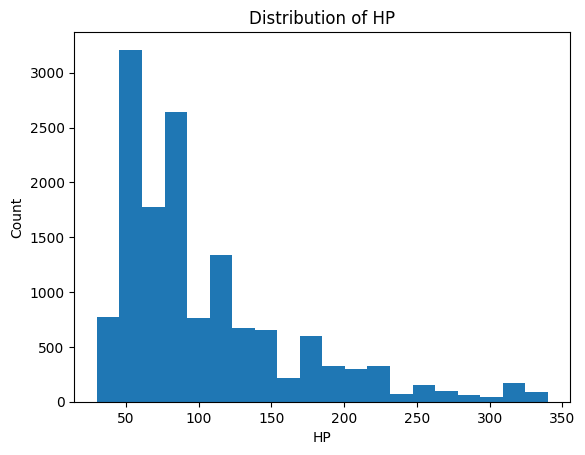

In [511]:
plt.hist(df["hp"].dropna(), bins=20)
plt.title("Distribution of HP")
plt.xlabel("HP")
plt.ylabel("Count")
plt.show()

⭕️ looks relavent to the price

## Attacks

In [512]:
df["attacks"][0]

"[{'name': 'Confuse Ray', 'cost': ['Psychic', 'Psychic', 'Psychic'], 'convertedEnergyCost': 3, 'damage': '30', 'text': 'Flip a coin. If heads, the Defending Pokémon is now Confused.'}]"

In [513]:
def extract_damage_with_symbol(attacks_str):
    if pd.isnull(attacks_str):
        return None
    try:
        attacks = ast.literal_eval(attacks_str)
        if isinstance(attacks, list) and len(attacks) > 0:
            last_attack = attacks[-1]
            damage = last_attack.get('damage', '')
            # Corrected regex pattern here:
            match = re.search(r'(\d+[+x]?)', damage)
            if match:
                return match.group(1)
            else:
                return None
    except Exception as e:
        print(f"Exception: {e}")
        return None

df['last_attack_damage'] = df['attacks'].apply(extract_damage_with_symbol)


In [514]:
# Null rate
null_rate = df['last_attack_damage'].isnull().mean()
print(f"Null rate is {100*null_rate}%")

Null rate is 11.283992150266329%


🔺 It might be hard to handle with both the ones with symbols and null values

## Weakness

In [515]:
df["weaknesses"]

0          [{'type': 'Psychic', 'value': '×2'}]
1        [{'type': 'Lightning', 'value': '×2'}]
2         [{'type': 'Fighting', 'value': '×2'}]
3            [{'type': 'Water', 'value': '×2'}]
4         [{'type': 'Fighting', 'value': '×2'}]
                          ...                  
16931         [{'type': 'Fire', 'value': '×2'}]
16932                                       NaN
16939    [{'type': 'Lightning', 'value': '×2'}]
16940        [{'type': 'Metal', 'value': '×2'}]
16941        [{'type': 'Grass', 'value': '×2'}]
Name: weaknesses, Length: 14268, dtype: object

❌ looks irrelevent

## Retreat Cost

In [516]:
df["retreatCost"]

0        ['Colorless', 'Colorless', 'Colorless']
1        ['Colorless', 'Colorless', 'Colorless']
2                                  ['Colorless']
3        ['Colorless', 'Colorless', 'Colorless']
4                                  ['Colorless']
                          ...                   
16931                 ['Colorless', 'Colorless']
16932                              ['Colorless']
16939                                        NaN
16940                 ['Colorless', 'Colorless']
16941                 ['Colorless', 'Colorless']
Name: retreatCost, Length: 14268, dtype: object

❌You can use convertedRetreatCost

## convertedRetreatCost

In [517]:
df["convertedRetreatCost"]

0        3.0
1        3.0
2        1.0
3        3.0
4        1.0
        ... 
16931    2.0
16932    1.0
16939    NaN
16940    2.0
16941    2.0
Name: convertedRetreatCost, Length: 14268, dtype: float64

In [518]:
# Null rate
null_rate = df["convertedRetreatCost"].isnull().mean()
print(f"Null rate is {100*null_rate}%")

Null rate is 5.649004765909728%


## rarity

In [519]:
# how many sets
print("Number of unique sets:", df['rarity'].nunique())

Number of unique sets: 30


In [520]:
df['rarity'].value_counts()

rarity
Common                       4128
Uncommon                     2648
Rare                         2201
Rare Holo                    1542
Promo                         955
Rare Ultra                    535
Rare Holo EX                  316
Rare Holo V                   282
Rare Rainbow                  244
Rare Holo GX                  163
Rare Secret                   151
Rare Shiny                    149
Illustration Rare             122
Rare Holo VMAX                110
Double Rare                    82
Trainer Gallery Rare Holo      80
Ultra Rare                     68
Rare Holo LV.X                 56
Rare Holo VSTAR                44
Rare Shiny GX                  35
Special Illustration Rare      33
Rare BREAK                     27
Rare Prime                     26
Rare Holo Star                 24
LEGEND                         18
Rare Prism Star                16
Rare Shining                   16
Radiant Rare                   15
Hyper Rare                     12
Amazing

In [521]:
rarity_group = {
    # 1. Common
    "Common": "Common",

    # 2. Uncommon
    "Uncommon": "Uncommon",
    "Promo": "Uncommon",
    "Trainer Gallery Rare Holo": "Uncommon",

    # 3. Rare
    "Rare": "Rare",
    "Rare Holo": "Rare",

    # 4. Ultra Rare
    "Rare Ultra": "Ultra Rare",
    "Rare Holo EX": "Ultra Rare",
    "Rare Holo V": "Ultra Rare",
    "Rare Holo GX": "Ultra Rare",

    # 5. VMAX/VSTAR Rare
    "Rare Holo VMAX": "VMAX Rare",
    "Rare Holo VSTAR": "VMAX Rare",

    # 6. Shiny/Radiant Rare
    "Radiant Rare": "Shiny Rare",
    "Rare Shiny": "Shiny Rare",
    "Rare Shiny GX": "Shiny Rare",
    "Rare Shining": "Shiny Rare",

    # 7. Rainbow/Secret Rare
    "Rare Rainbow": "Secret Rare",
    "Rare Secret": "Secret Rare",

    # 8. Elite Rare (high-tier playable/legacy cards)
    "Double Rare": "Elite Rare",
    "Rare BREAK": "Elite Rare",
    "Rare Prime": "Elite Rare",
    "Rare Holo LV.X": "Elite Rare",
    "Rare Holo Star": "Elite Rare",
    "Rare Prism Star": "Elite Rare",

    # 9. Special Illustration / Collection Rare
    "Illustration Rare": "Special Rare",
    "Special Illustration Rare": "Special Rare",
    "Classic Collection": "Special Rare",
    "LEGEND": "Special Rare",
    "Hyper Rare": "Special Rare",
    "Amazing Rare": "Special Rare"
}

df['rarity_grouped'] = df['rarity'].map(rarity_group)

In [522]:
df["rarity_grouped"].value_counts()

rarity_grouped
Common          4128
Rare            3743
Uncommon        3683
Ultra Rare      1296
Secret Rare      395
Elite Rare       231
Shiny Rare       215
Special Rare     194
VMAX Rare        154
Name: count, dtype: int64

⭕️looks useful

## legalities

In [523]:
df["legalities"].value_counts()

legalities
{'unlimited': 'Legal', 'expanded': 'Legal'}                         6412
{'unlimited': 'Legal'}                                              4739
{'unlimited': 'Legal', 'standard': 'Legal', 'expanded': 'Legal'}    3098
{'unlimited': 'Legal', 'expanded': 'Banned'}                          14
{'unlimited': 'Banned'}                                                5
Name: count, dtype: int64

❌It is hard to understand what are leagal

## Possible Useful columns

In [524]:
columns = ["id", "series","generation", "single_type","hp","subtypes","last_attack_damage", "convertedRetreatCost","rarity_grouped","market_price","market_price_log",'name_counts']

In [525]:
df = df[columns]
df.head()

,id,series,generation,single_type,hp,subtypes,last_attack_damage,convertedRetreatCost,rarity_grouped,market_price,market_price_log,name_counts
0,base1-1,Base,First,Psychic,80.0,['Stage 2'],30,3.0,Rare,133.99,4.905201,19
1,base1-2,Base,First,Water,100.0,['Stage 2'],40+,3.0,Rare,93.95,4.553350,28
2,base1-3,Base,First,Colorless,120.0,['Basic'],80,1.0,Rare,23.63,3.203965,22
3,base1-4,Base,First,Fire,120.0,['Stage 2'],100,3.0,Rare,5527.50,8.617672,64
4,base1-5,Base,First,Colorless,40.0,['Basic'],None,1.0,Rare,23.18,3.185526,29


# Data Cleaning

In [526]:
df.head()

,id,series,generation,single_type,hp,subtypes,last_attack_damage,convertedRetreatCost,rarity_grouped,market_price,market_price_log,name_counts
0,base1-1,Base,First,Psychic,80.0,['Stage 2'],30,3.0,Rare,133.99,4.905201,19
1,base1-2,Base,First,Water,100.0,['Stage 2'],40+,3.0,Rare,93.95,4.553350,28
2,base1-3,Base,First,Colorless,120.0,['Basic'],80,1.0,Rare,23.63,3.203965,22
3,base1-4,Base,First,Fire,120.0,['Stage 2'],100,3.0,Rare,5527.50,8.617672,64
4,base1-5,Base,First,Colorless,40.0,['Basic'],None,1.0,Rare,23.18,3.185526,29


In [527]:
df.isna().sum()

id                         0
series                     0
generation                 0
single_type                0
hp                         0
subtypes                   0
last_attack_damage      1610
convertedRetreatCost     806
rarity_grouped           229
market_price               0
market_price_log           0
name_counts                0
dtype: int64

In [528]:
# You might be able to use last_attack_damage to predict the price but for now we will drop it
df = df.drop(columns=["last_attack_damage"])

In [529]:
df = df.dropna()
df.isna().sum()

id                      0
series                  0
generation              0
single_type             0
hp                      0
subtypes                0
convertedRetreatCost    0
rarity_grouped          0
market_price            0
market_price_log        0
name_counts             0
dtype: int64

# Pipeline(Feature Engineering,Train_Test_Split,Modeling and Evaluation)

In [530]:
df.columns

Index(['id', 'series', 'generation', 'single_type', 'hp', 'subtypes',
       'convertedRetreatCost', 'rarity_grouped', 'market_price',
       'market_price_log', 'name_counts'],
      dtype='object')

In [531]:
# Calculate correlation matrix for all numeric columns
correlation_table = df[['hp', 'convertedRetreatCost', 'market_price_log']].corr()

print(correlation_table)

                            hp  convertedRetreatCost  market_price_log
hp                    1.000000              0.492520          0.366091
convertedRetreatCost  0.492520              1.000000          0.180873
market_price_log      0.366091              0.180873          1.000000


In [532]:
df

,id,series,generation,single_type,hp,subtypes,convertedRetreatCost,rarity_grouped,market_price,market_price_log,name_counts
0,base1-1,Base,First,Psychic,80.0,['Stage 2'],3.0,Rare,133.99,4.905201,19
1,base1-2,Base,First,Water,100.0,['Stage 2'],3.0,Rare,93.95,4.553350,28
2,base1-3,Base,First,Colorless,120.0,['Basic'],1.0,Rare,23.63,3.203965,22
3,base1-4,Base,First,Fire,120.0,['Stage 2'],3.0,Rare,5527.50,8.617672,64
4,base1-5,Base,First,Colorless,40.0,['Basic'],1.0,Rare,23.18,3.185526,29
...,...,...,...,...,...,...,...,...,...,...,...
16930,sv4-251,Scarlet & Violet,Ninth,Darkness,230.0,"['Basic', 'ex', 'Ancient']",2.0,Special Rare,48.05,3.892840,4
16931,sv4-252,Scarlet & Violet,Ninth,Metal,260.0,"['Stage 1', 'ex']",2.0,Special Rare,24.98,3.257327,3
16932,sv4-253,Scarlet & Violet,Ninth,Dragon,260.0,"['Stage 1', 'ex']",1.0,Special Rare,57.79,4.073972,33
16940,sv4-261,Scarlet & Violet,Ninth,Psychic,220.0,"['Basic', 'ex', 'Future']",2.0,Special Rare,4.54,1.711995,4


In [533]:
# Pipeline for Machine Learning
X = df.columns.drop(["market_price_log", "market_price_log"]).tolist()
y = ["market_price_log"]

X_train, X_test, y_train, y_test = train_test_split(df[X], df[y], test_size=0.2, random_state=42)

# Identify categorical and numeric columns
categorical_cols = ['series', 'generation','single_type','subtypes']
numeric_cols = ['hp','name_counts']
ordinal_col = ['rarity_grouped']

ordinal_transformer = OrdinalEncoder(categories=[[
    "Common",
    "Uncommon",
    "Rare",
    "Ultra Rare",
    "VMAX Rare",
    "Shiny Rare",
    "Secret Rare",
    "Elite Rare",
    "Special Rare"
]])

# Define preprocessing for categorical data: OneHotEncoding
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Define preprocessing for numeric data: scaling
numeric_transformer = StandardScaler()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_cols),
        ('ord', ordinal_transformer, ordinal_col),
        ('num', numeric_transformer, numeric_cols)
    ]
)
# Create the full pipeline including the model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Fit pipeline on training data (this fits preprocessing and the model)
pipeline.fit(X_train, y_train)

# Predict or evaluate on test data (this applies the exact same preprocessing)
y_pred = pipeline.predict(X_test)

r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


R-squared: 0.6944759192633969


In [534]:
# Features for the model

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

print(feature_names)

['cat__series_Base' 'cat__series_Black & White'
 'cat__series_Diamond & Pearl' 'cat__series_E-Card' 'cat__series_EX'
 'cat__series_Gym' 'cat__series_HeartGold & SoulSilver' 'cat__series_NP'
 'cat__series_Neo' 'cat__series_Other' 'cat__series_POP'
 'cat__series_Platinum' 'cat__series_Scarlet & Violet'
 'cat__series_Sun & Moon' 'cat__series_Sword & Shield' 'cat__series_XY'
 'cat__generation_Eighth' 'cat__generation_Fifth' 'cat__generation_First'
 'cat__generation_Fourth' 'cat__generation_Fourth '
 'cat__generation_Ninth' 'cat__generation_Second'
 'cat__generation_Seventh' 'cat__generation_Sixth' 'cat__generation_Third'
 'cat__single_type_Colorless' 'cat__single_type_Darkness'
 'cat__single_type_Dragon' 'cat__single_type_Fairy'
 'cat__single_type_Fighting' 'cat__single_type_Fire'
 'cat__single_type_Grass' 'cat__single_type_Lightning'
 'cat__single_type_Metal' 'cat__single_type_Psychic'
 'cat__single_type_Water' "cat__subtypes_['Baby']"
 "cat__subtypes_['Basic', 'Ancient']"
 "cat__subtypes

# Pipeline(Grid Search)

In [535]:
param_grid = [
{
        'regressor': [LGBMRegressor(random_state=42)],
        'regressor__n_estimators': [210],
        'regressor__learning_rate': [1.99, 0.2,0.201],
        'regressor__max_depth': [4.999, 5]
    }]


# param_grid = [
# {
#         'regressor': [LGBMRegressor(random_state=42)],
#         'regressor__n_estimators': [50, 100, 200, 250, 300],
#         'regressor__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
#         'regressor__max_depth': [-1, 5, 10, 15]
#     }]
# param_grid = [
#     {
#         'regressor': [LinearRegression()],
#         'regressor__fit_intercept': [True, False],
#         'regressor__positive': [True, False]
#     },
#     {
#         'regressor': [Ridge()],
#         'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0],
#         'regressor__solver': ['auto', 'svd', 'cholesky', 'saga']
#     },
#     {
#         'regressor': [Lasso(max_iter=5000)],
#         'regressor__alpha': [0.001, 0.01, 0.1, 1.0, 10.0]
#     },
#     {
#         'regressor': [ElasticNet(max_iter=5000)],
#         'regressor__alpha': [0.001, 0.01, 0.1, 1.0],
#         'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
#     },
#     {
#         'regressor': [RandomForestRegressor(random_state=42)],
#         'regressor__n_estimators': [50, 100, 200],
#         'regressor__max_depth': [None, 10, 20],
#         'regressor__min_samples_split': [2, 5]
#     },
#     {
#         'regressor': [GradientBoostingRegressor(random_state=42)],
#         'regressor__n_estimators': [50, 100, 200],
#         'regressor__learning_rate': [0.01, 0.05, 0.1],
#         'regressor__max_depth': [3, 5, 7]
#     },
#     {
#         'regressor': [HistGradientBoostingRegressor(random_state=42)],
#         'regressor__max_iter': [100, 200],
#         'regressor__learning_rate': [0.01, 0.05, 0.1],
#         'regressor__max_depth': [None, 10, 20]
#     },
#     {
#         'regressor': [AdaBoostRegressor(random_state=42)],
#         'regressor__n_estimators': [50, 100, 200],
#         'regressor__learning_rate': [0.01, 0.1, 1.0]
#     },
#     {
#         'regressor': [SVR()],
#         'regressor__kernel': ['linear', 'rbf'],
#         'regressor__C': [0.1, 1, 10],
#         'regressor__epsilon': [0.01, 0.1, 1.0]
#     },
#     {
#         'regressor': [KNeighborsRegressor()],
#         'regressor__n_neighbors': [3, 5, 7, 9],
#         'regressor__weights': ['uniform', 'distance']
#     },
#     {
#         'regressor': [DecisionTreeRegressor(random_state=42)],
#         'regressor__max_depth': [None, 5, 10, 20],
#         'regressor__min_samples_split': [2, 5, 10]
#     },
#     {
#         'regressor': [DummyRegressor()],
#         'regressor__strategy': ['mean', 'median']
#     },
#     {
#         'regressor': [XGBRegressor(random_state=42, verbosity=0)],
#         'regressor__n_estimators': [50, 100, 200],
#         'regressor__learning_rate': [0.01, 0.05, 0.1],
#         'regressor__max_depth': [3, 5, 7]
#     },
#     {
#         'regressor': [LGBMRegressor(random_state=42)],
#         'regressor__n_estimators': [50, 100, 200],
#         'regressor__learning_rate': [0.01, 0.05, 0.1],
#         'regressor__max_depth': [-1, 5, 10]
#     },
#     {
#         'regressor': [MLPRegressor(max_iter=1000, random_state=42)],
#         'regressor__hidden_layer_sizes': [(50,), (100,), (100, 50), (100, 50, 25)],
#         'regressor__activation': ['relu', 'tanh'],
#         'regressor__solver': ['adam'],
#         'regressor__alpha': [0.0001, 0.001, 0.01],
#         'regressor__learning_rate': ['constant', 'adaptive']
#     }
# ]


In [536]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train.values.ravel())  # Flatten y to 1D if it's a DataFrame

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 8476, number of used features: 65
[LightGBM] [Info] Start training from score 1.024740
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000687 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 210
[LightGBM] [Info] Number of da

[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"
[LightGBM] [Fatal] Parameter max_depth should be of type int, got "4.999"


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000521 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 216
[LightGBM] [Info] Number of data points in the train set: 8476, number of used features: 65
[LightGBM] [Info] Start training from score 1.007777
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Tracebac

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['series',
                                                                          'generation',
                                                                          'single_type',
                                                                          'subtypes']),
                                                                        ('ord',
                                                                         OrdinalEncoder(categories=[['Common',
                                                                                                     'Uncommon',
                                                                                                     'Rare',
                                                                                                     'Ultra '
                                                                                                     'Rare',
                                                                                                     'VMAX '
                                                                                                     'Rare',
                                                                                                     'Shiny '
                                                                                                     'Rare',
                                                                                                     'Secret '
                                                                                                     'Rare',
                                                                                                     'Elite '
                                                                                                     'Rare',
                                                                                                     'Special '
                                                                                                     'Rare']]),
                                                                         ['rarity_grouped']),
                                                                        ('num',
                                                                         StandardScaler(),
                                                                         ['hp',
                                                                          'name_counts'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid=[{'regressor': [LGBMRegressor(random_state=42)],
                          'regressor__learning_rate': [1.99, 0.2, 0.201],
                          'regressor__max_depth': [4.999, 5],
                          'regressor__n_estimators': [210]}],
             scoring='r2', verbose=1)

In [537]:
print("Best parameters:", grid_search.best_params_)
print("Best R² score on CV:", grid_search.best_score_)

y_pred = grid_search.predict(X_test)
print("Test R² score:", r2_score(y_test, y_pred))

Best parameters: {'regressor': LGBMRegressor(random_state=42), 'regressor__learning_rate': 0.2, 'regressor__max_depth': 5, 'regressor__n_estimators': 210}
Best R² score on CV: 0.7457402153431143
Test R² score: 0.7494888374546955


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# Save the model

In [538]:
# Save the model
script_dir = os.getcwd()
path = os.path.join(script_dir, "../../Models/Prediction_Module/")
os.makedirs(path, exist_ok=True)  # Ensure the directory exists

# Full path for the model file
model_path = os.path.join(path, "pokemon_price_model.pkl")

# Save the model
joblib.dump(grid_search.best_estimator_, model_path)
model = joblib.load("pokemon_price_model.pkl")

In [539]:
model = joblib.load("pokemon_price_model.pkl")

# System Analysis

In [540]:
df["predicted_price_log"] = model.predict(df[X])
df["predicted_price"] = np.expm1(df["predicted_price_log"])

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [541]:
# Understand the price difference
print(f'market_price_sum:{df["market_price"].sum()},predicted_price_sum:{df["predicted_price"].sum()}')

market_price_sum:135687.47999999998,predicted_price_sum:85329.22962472294


In [542]:
# Understand the price difference
print(f'market_price_sum_log:{df["market_price_log"].sum()},predicted_price_log_sum:{df["predicted_price_log"].sum()}')

market_price_sum_log:13182.116299082454,predicted_price_log_sum:13196.636105381125


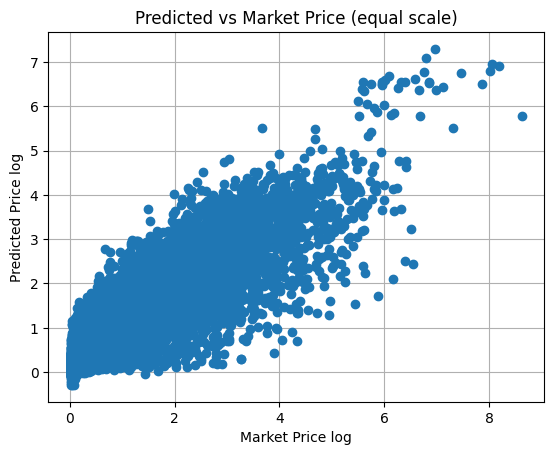

In [543]:
plt.plot(df["market_price_log"], df["predicted_price_log"], 'o')
plt.xlabel("Market Price log")
plt.ylabel("Predicted Price log")
plt.title("Predicted vs Market Price (equal scale)")
plt.grid(True)
plt.show()

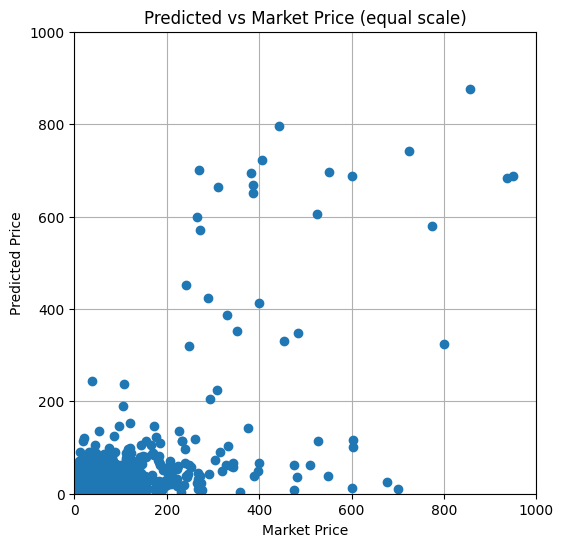

In [544]:
# predicted vs market price
plt.figure(figsize=(6, 6))  # Make sure plot is square
plt.plot(df["market_price"], df["predicted_price"], 'o')

# Set limits before setting equal aspect
plt.xlim(0, 1000)
plt.ylim(0, 1000)

# Equal aspect ratio (forces scaling, not just limits)
plt.gca().set_aspect('equal', adjustable='box')  # This works better than plt.axis('equal')

plt.xlabel("Market Price")
plt.ylabel("Predicted Price")
plt.title("Predicted vs Market Price (equal scale)")
plt.grid(True)
plt.show()

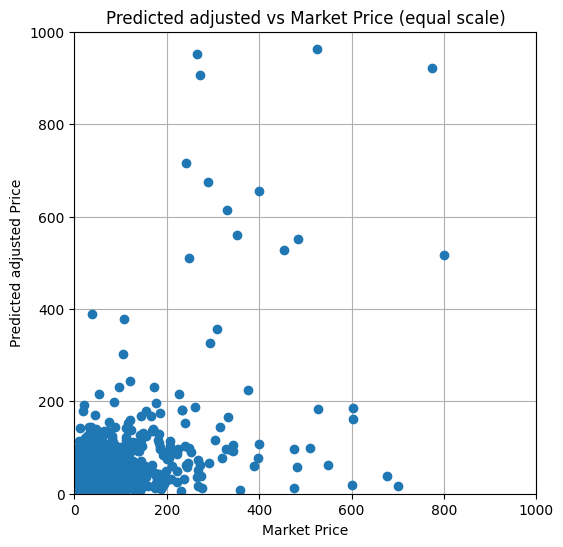

In [545]:

# predicted adjusted vs market price
a=df["market_price"].sum()/df["predicted_price"].sum()
df["predicted_price_adjusted"] = df["predicted_price"] * a

plt.figure(figsize=(6, 6))  # Make sure plot is square
plt.plot(df["market_price"], df["predicted_price_adjusted"], 'o')

# Set limits before setting equal aspect
plt.xlim(0, 1000)
plt.ylim(0, 1000)

# Equal aspect ratio (forces scaling, not just limits)
plt.gca().set_aspect('equal', adjustable='box')  # This works better than plt.axis('equal')

plt.xlabel("Market Price")
plt.ylabel("Predicted adjusted Price")
plt.title("Predicted adjusted vs Market Price (equal scale)")
plt.grid(True)
plt.show()


In [546]:
df["over_or_under_valued_log"] = np.where(
    df["predicted_price_log"] - df["market_price_log"] >= 0,
    "undervalued",
    "overvalued"  # You had `else 0`, but usually you'd want to label it
)

In [547]:
# Understand the price difference of the adjusted predicted price
print(f'market_price_sum:{df["market_price"].sum()},predicted_price_sum:{df["predicted_price_adjusted"].sum()}')

market_price_sum:135687.47999999998,predicted_price_sum:135687.47999999995


# How the model takes an input(Overvalued or Undervalued?)

In [548]:
# New data just with id
new_data = df[df["id"]=="bw9-118"]
new_data

,id,series,generation,single_type,hp,subtypes,convertedRetreatCost,rarity_grouped,market_price,market_price_log,name_counts,predicted_price_log,predicted_price,predicted_price_adjusted,over_or_under_valued_log
6803,bw9-118,Black & White,Fifth,Psychic,90.0,['Basic'],1.0,Secret Rare,52.66,3.982668,14,3.684507,38.825473,61.738874,overvalued


In [549]:
model.predict(new_data)

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


array([3.68450673])

In [550]:
if new_data["market_price_log"].values[0] > model.predict(new_data):
    print("Overvalued!")
else:
    print("Undervalued!")

Overvalued!


/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


# How the model takes an input(Recommendation with Budget)

In [551]:
df["predicted_price_log"] = model.predict(df[X])
df["predicted_price"] = np.expm1(df["predicted_price_log"])

/Users/suzukikenta/.pyenv/versions/3.10.6/envs/Pokemon/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [552]:
df["single_type"].value_counts()

single_type
Water        1971
Grass        1816
Psychic      1785
Colorless    1641
Fighting     1493
Fire         1189
Lightning    1115
Darkness      890
Metal         727
Dragon        402
Fairy         215
Name: count, dtype: int64

In [597]:
# The best card within the budget
budget = int(input("Enter your budget (EUR): "))
poke_type = input("Enter the type: ")
generation = input("Enter the generation (leave blank to skip): ")

poke_types = df["single_type"].unique().tolist()
generations = df["generation"].unique().tolist()

filtered_df = df[
    (df["market_price"] <= budget) &
    ((df["single_type"] == poke_type) | (poke_type not in poke_types)) &
    ((df["generation"] == generation) | (generation not in generations))
]


# Filter to best predicted price
filtered_df = filtered_df[filtered_df["predicted_price"] == filtered_df["predicted_price"].max()]

# Split ID into set_id and card_id
filtered_df[['set_id', 'card_id']] = filtered_df['id'].str.split('-', expand=True)

# Final output
filtered_df = filtered_df[['set_id', 'card_id','single_type', 'generation',  'market_price', 'predicted_price', 'predicted_price_adjusted']]
filtered_df = filtered_df.sort_values(by='market_price', ascending=True)

filtered_df


,set_id,card_id,single_type,generation,market_price,predicted_price,predicted_price_adjusted
431,base5,21,Fire,First,52.67,136.195766,216.573622


The predicted price is 136.2EUR. The market price is 52.7 EUR.


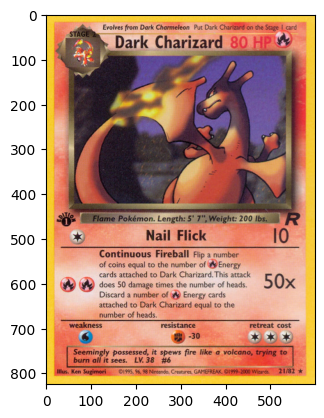

In [598]:
#Show the best card within the budget
url = f"https://images.pokemontcg.io/{filtered_df['set_id'].iloc[0]}/{filtered_df['card_id'].iloc[0]}_hires.png"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

# witht its price
print(f"The predicted price is {filtered_df['predicted_price'].values[0]:.1f}EUR. The market price is {round(filtered_df['market_price'].values[0],1)} EUR.")

In [599]:
# The card with the biggest diff between predicted and market prices
budget_2 = int(input("Enter your budget (EUR): "))
poke_type_2= input("Enter the type: ")
generation_2 = input("Enter the generation (leave blank to skip): ")

poke_types = df["single_type"].unique().tolist()
generations = df["generation"].unique().tolist()

filtered_df_2 = df[
    (df["market_price"] <= budget) &
    ((df["single_type"] == poke_type_2) | (poke_type not in poke_types)) &
    ((df["generation"] == generation_2) | (generation not in generations))
]


# Filter to best predicted price
diff = (filtered_df_2["predicted_price"] - filtered_df_2["market_price"])
filtered_df_2 = filtered_df_2[diff == diff.max()]


filtered_df_2[['set_id', 'card_id']] = filtered_df_2['id'].str.split('-', expand=True)

# Final output
filtered_df_2 = filtered_df_2[['set_id', 'card_id','single_type', 'generation', 'market_price', 'predicted_price', 'predicted_price_adjusted']]
filtered_df_2 = filtered_df_2.sort_values(by='market_price', ascending=True)

filtered_df_2

,set_id,card_id,single_type,generation,market_price,predicted_price,predicted_price_adjusted
1290,ecard1,40,Fire,Second,18.09,113.211963,180.025603


The predicted price is 113.2EUR. The market price is 18.1 EUR.


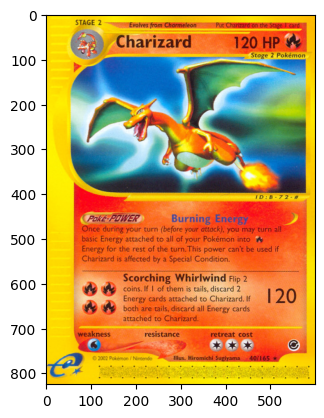

In [600]:
#Show the best card within the budget
url = f"https://images.pokemontcg.io/{filtered_df_2['set_id'].iloc[0]}/{filtered_df_2['card_id'].iloc[0]}_hires.png"

response = requests.get(url)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

# witht its price
print(f"The predicted price is {filtered_df_2['predicted_price'].values[0]:.1f}EUR. The market price is {round(filtered_df_2['market_price'].values[0],1)} EUR.")

# Additional information

In [566]:
type = df["single_type"].unique()

for i in type:
    ty = df[df["single_type"]==i]
    undervalued_rate = ty[ty["predicted_price_log"] >= ty["market_price_log"]].shape[0] / ty.shape[0]
    print(f"{i}'s undervalued rate is {undervalued_rate:.2%}.")

Psychic's undervalued rate is 57.82%.
Water's undervalued rate is 60.38%.
Colorless's undervalued rate is 62.28%.
Fire's undervalued rate is 59.46%.
Fighting's undervalued rate is 53.32%.
Lightning's undervalued rate is 59.28%.
Grass's undervalued rate is 60.63%.
Metal's undervalued rate is 58.87%.
Darkness's undervalued rate is 59.44%.
Dragon's undervalued rate is 62.19%.
Fairy's undervalued rate is 61.40%.


# Export the dataframes with the model outputs

In [558]:
df.columns

Index(['id', 'series', 'generation', 'single_type', 'hp', 'subtypes',
       'convertedRetreatCost', 'rarity_grouped', 'market_price',
       'market_price_log', 'name_counts', 'predicted_price_log',
       'predicted_price', 'predicted_price_adjusted',
       'over_or_under_valued_log'],
      dtype='object')

In [559]:
df[['set_id', 'card_id']] = df['id'].str.split('-', expand=True)
df_1 = df[["set_id", "card_id", "predicted_price", "market_price", "single_type", "generation","over_or_under_valued_log"]]

In [560]:
script_dir = os.getcwd()  # current working directory
path = os.path.join(script_dir, "../../Data/Raw/")

# Save the DataFrame with prediction outputs to a CSV file
df_1.to_csv(os.path.join(path, "prediction_model.csv"), index=False)

# Save the DataFrame with prediction outputs to a CSV file
df_market.to_csv(os.path.join(path, "market_price.csv"), index=False)

In [561]:
df

,id,series,generation,single_type,hp,subtypes,convertedRetreatCost,rarity_grouped,market_price,market_price_log,name_counts,predicted_price_log,predicted_price,predicted_price_adjusted,over_or_under_valued_log,set_id,card_id
0,base1-1,Base,First,Psychic,80.0,['Stage 2'],3.0,Rare,133.99,4.905201,19,3.010390,19.295305,30.682702,overvalued,base1,1
1,base1-2,Base,First,Water,100.0,['Stage 2'],3.0,Rare,93.95,4.553350,28,4.052299,56.529549,89.891261,overvalued,base1,2
2,base1-3,Base,First,Colorless,120.0,['Basic'],1.0,Rare,23.63,3.203965,22,2.413097,10.168494,16.169574,overvalued,base1,3
3,base1-4,Base,First,Fire,120.0,['Stage 2'],3.0,Rare,5527.50,8.617672,64,5.773288,320.593245,509.795877,overvalued,base1,4
4,base1-5,Base,First,Colorless,40.0,['Basic'],1.0,Rare,23.18,3.185526,29,2.618556,12.715899,20.220367,overvalued,base1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16930,sv4-251,Scarlet & Violet,Ninth,Darkness,230.0,"['Basic', 'ex', 'Ancient']",2.0,Special Rare,48.05,3.892840,4,2.587300,12.293823,19.549197,overvalued,sv4,251
16931,sv4-252,Scarlet & Violet,Ninth,Metal,260.0,"['Stage 1', 'ex']",2.0,Special Rare,24.98,3.257327,3,1.861828,5.435487,8.643316,overvalued,sv4,252
16932,sv4-253,Scarlet & Violet,Ninth,Dragon,260.0,"['Stage 1', 'ex']",1.0,Special Rare,57.79,4.073972,33,3.937347,50.282393,79.957257,overvalued,sv4,253
16940,sv4-261,Scarlet & Violet,Ninth,Psychic,220.0,"['Basic', 'ex', 'Future']",2.0,Special Rare,4.54,1.711995,4,2.563289,11.978429,19.047668,undervalued,sv4,261


In [595]:
df["single_type"].value_counts()

single_type
Water        1971
Grass        1816
Psychic      1785
Colorless    1641
Fighting     1493
Fire         1189
Lightning    1115
Darkness      890
Metal         727
Dragon        402
Fairy         215
Name: count, dtype: int64

In [ ]:
df["s"]